## Set-up 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

/home/evgeniy/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import sklearn 
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split

In [3]:
plt.rcParams.update({"figure.figsize": (20, 6)})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Initial approach

### Preprocessing

In [4]:
events = pd.read_csv('int20h-ds-test-dataset.csv')

In [5]:
events.head(5)

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""White"",""Year"":""2019"",""Temporary"":""false"",""Start Date"":"""",""End Date"":"""",""Rental state"":""""}",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


In [6]:
device_manufacture = dict(events[['device_model', 'device_manufacture']].values)
device_platform = dict(events[['device_model', 'event_platform']].values)

In [7]:
set(events.loc[events['userid'] == "46c1d5ea297bd502e2d7f9dba6056bdd",'device_model'].values)

{'Alcatel_5002R', 'iPhone12,1', nan}

In [8]:
def nth_unique(n=1):
    def _nth_unique(x):
        uniq = list(set(x[x.notna()]))
        return uniq[n-1] if len(uniq) > n-1 else "None"
    return _nth_unique
    
users_info = events[['userid', 'user_state', 'device_model']].groupby('userid').agg(
    user_state=pd.NamedAgg("user_state", lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "None"),
    device1=pd.NamedAgg("device_model", nth_unique(n=1)),
    device2=pd.NamedAgg("device_model", nth_unique(n=2)),
    device3=pd.NamedAgg("device_model", nth_unique(n=3))
)

In [9]:
for i in range(1, 4):
    users_info[f'device{i}_manufacture'] = users_info[f'device{i}'].map(device_manufacture)
    users_info[f'device{i}_platform'] = users_info[f'device{i}'].map(device_platform)

In [10]:
users_info = users_info.astype(dtype={
   col : "category" for col in users_info.columns
})

In [11]:
users_info[~(users_info['device3'] == "None")]

,user_state,device1,device2,device3,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,
423ffa8cbe761baa995e981904f479db,CA,SM-G998U1,SM-G981U,SM-G996U1,samsung,android,samsung,android,samsung,android


In [12]:
users = events[['userid', 'event_name']].groupby(['userid', 'event_name']).agg(
    count_col=pd.NamedAgg(column="event_name", aggfunc='count')
)
users = users.unstack(fill_value=0)
users.columns = [col[1] for col in users.columns]

In [13]:
users = users.join(users_info) 

In [14]:
users

,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Cancel,Subscription Premium Renew,Transaction Refund,Wallet Opened,user_state,device1,device2,device3,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,MD,SM-A716U,None,None,samsung,android,NaN,NaN,NaN,NaN
000a59897372c5e3c147b15685fefc65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,"iPhone11,6",None,None,Apple,ios,NaN,NaN,NaN,NaN
001244c572f1a681553bc045a378cacf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,FL,SM-G780G,None,None,samsung,android,NaN,NaN,NaN,NaN
0032cb66b99f6baef57ec2aa04a9277f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,"iPhone14,3",None,None,Apple,ios,NaN,NaN,NaN,NaN
003f57fe2631ade57a86f6a2b96bb20c,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,"iPhone13,4",None,None,Apple,ios,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff9fd3437958123842f3ab75d22fc13f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,SM-N960U,None,None,samsung,android,NaN,NaN,NaN,NaN
ffa1aa12dd53aee84976cb6c525bb17b,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,TX,"iPhone12,1",None,None,Apple,ios,NaN,NaN,NaN,NaN
ffbbc97af52745060a9dff4eb9917f75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,PA,"iPhone12,1",None,None,Apple,ios,NaN,NaN,NaN,NaN


### Baseline xgboost

In [15]:
users_premium = users[(users['Subscription Premium'] > 0) | 
                      (users['Subscription Premium Renew'] > 0) |
                      (users['Subscription Premium Cancel'] > 0)]

In [16]:
X = users.drop(columns=["Subscription Premium Cancel"])
y = users["Subscription Premium Cancel"] > 0

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [18]:
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

In [19]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

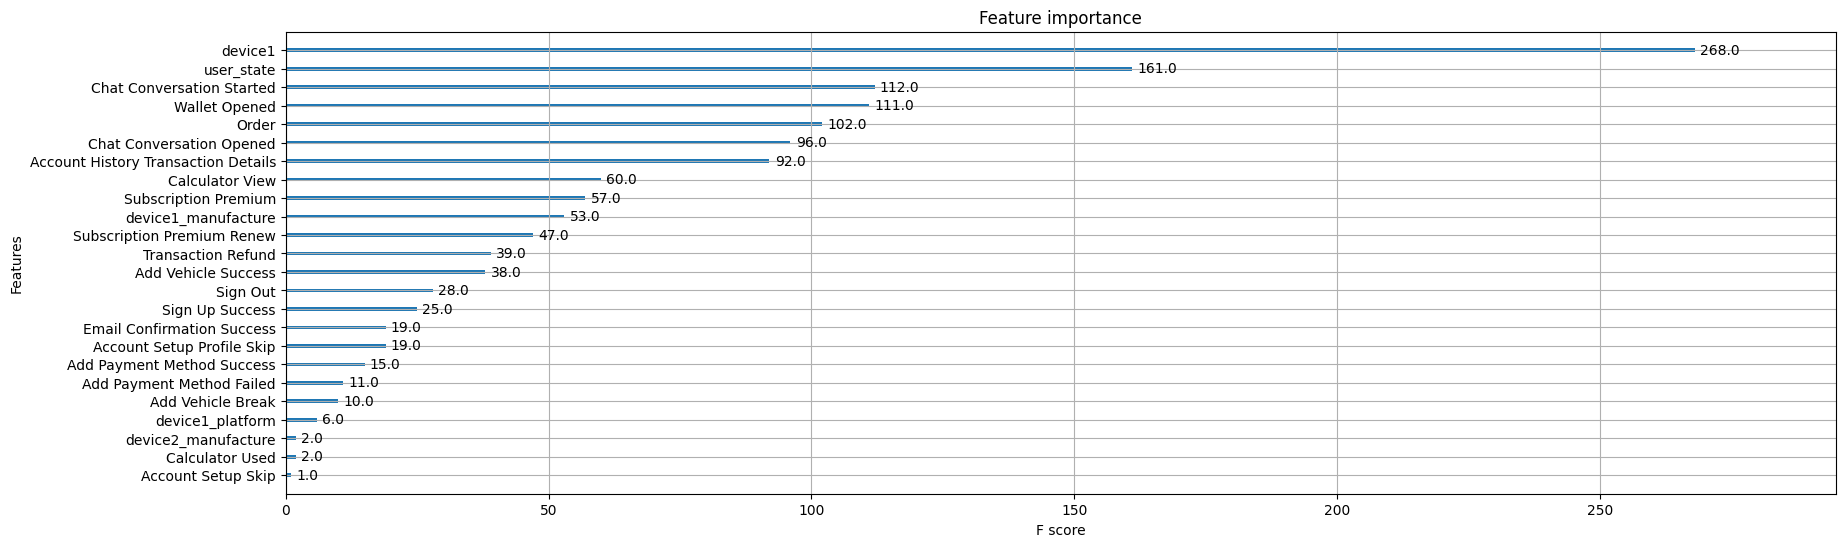

In [20]:
xgb.plot_importance(model)
plt.show()

In [21]:
y_test_pred = model.predict(X_test)

In [22]:
accuracy_score(y_test, y_test_pred)

0.9559322033898305

In [23]:
precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

(0.6911764705882353, 0.7230769230769231)

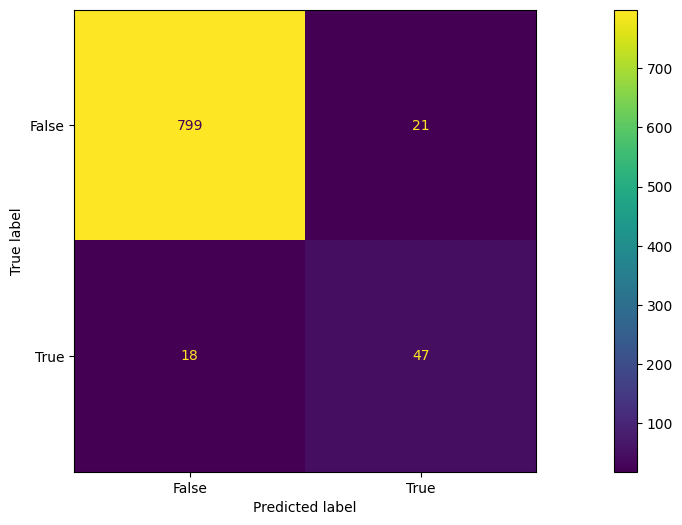

In [24]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

### Devices analysis

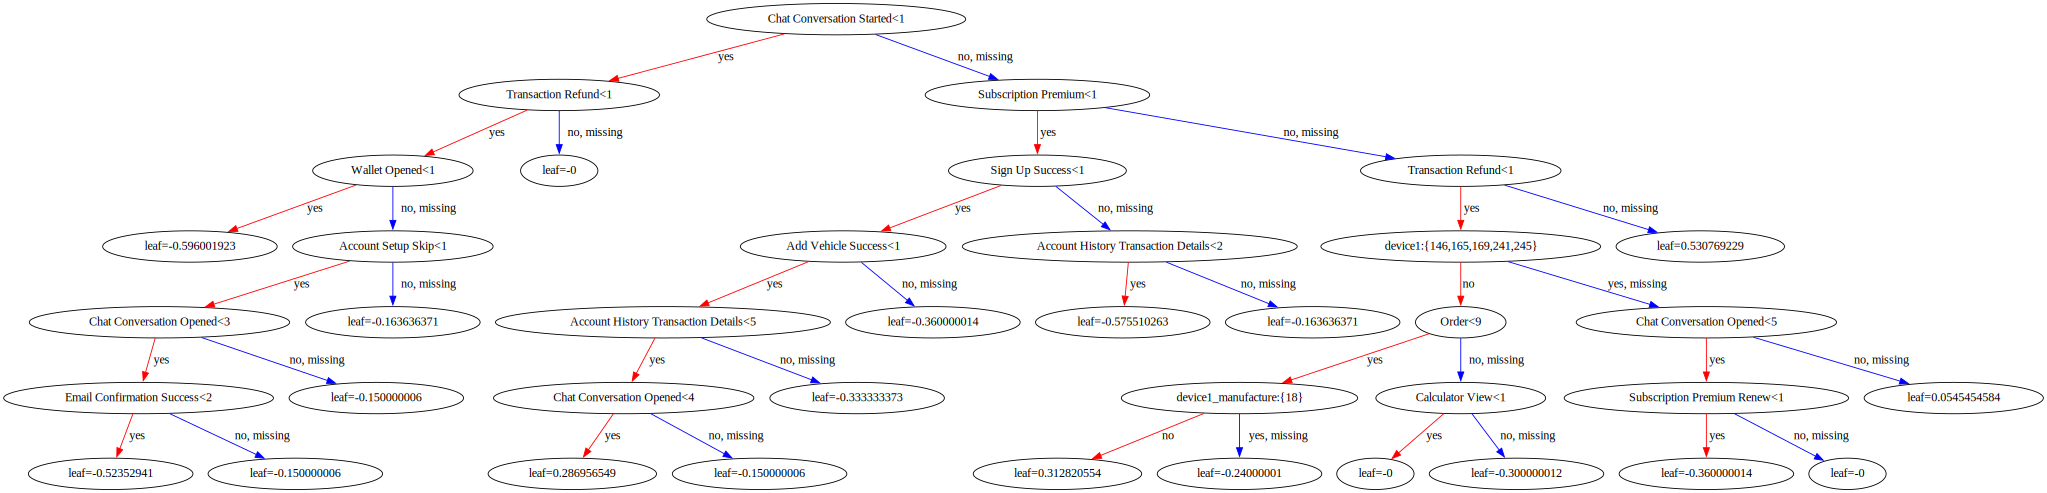

In [26]:
xgb.to_graphviz(model) 

In [ ]:
model.kjii

### Users and devices

In [287]:
events[['userid', 'device_model']].groupby('userid').nunique().sort_values('device_model', ascending=False)

,device_model
userid,
423ffa8cbe761baa995e981904f479db,3
604062fd35365e259606987533396503,2
d29f9eabe3c60abf6285269dc49363cf,2
c1955c6e5cb8a393d9bcf8461c88c73a,2
fd4a11b9abba7352308fabf80c122501,2
...,...
b8cdde221aae75d37c0996c030e05521,0
a2e02c36f2999fdcd0f43c7d236f8b98,0
f7969f6c5da30b31f73be28b6459d221,0


In [288]:
events[['userid', 'user_state']].groupby('userid').nunique().sort_values('user_state', ascending=False)

,user_state
userid,
0006869712ec9841dc36234bce245203,1
ab48659559affb5671813091c363e359,1
aa732ee45505a789aeb6f4002d0ee3e7,1
aa7a662047b22ac923f219ba4f43b62f,1
aaaaecf9ad6c41b0db2736bf12b5b5b3,1
...,...
d9f6078c032ef4dcbed653d4187ef17e,0
c41b93b5910899817515d100c16fd8f5,0
b3cd5319263fe5aee1e1b4ed3a9e987f,0


## Second approach

### Preprocessing

In [174]:
events = pd.read_csv('int20h-ds-test-dataset.csv')

In [175]:
events.head(5)

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""White"",""Year"":""2019"",""Temporary"":""false"",""Start Date"":"""",""End Date"":"""",""Rental state"":""""}",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


In [176]:
device_manufacture = dict(events[['device_model', 'device_manufacture']].values)
device_platform = dict(events[['device_model', 'event_platform']].values)

In [177]:
set(events.loc[events['userid'] == "46c1d5ea297bd502e2d7f9dba6056bdd",'device_model'].values)

{'Alcatel_5002R', 'iPhone12,1', nan}

In [199]:
def nth_unique(n=1):
    def _nth_unique(x):
        uniq = list(set(x[x.notna()]))
        return uniq[n-1] if len(uniq) > n-1 else "None"
    return _nth_unique
    
users_info = events[['userid', 'user_state', 'device_model', 'event_name']].groupby('userid').agg(
    user_state=pd.NamedAgg("user_state", lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "None"),
    device1=pd.NamedAgg("device_model", nth_unique(n=1)),
    device2=pd.NamedAgg("device_model", nth_unique(n=2)),
    device3=pd.NamedAgg("device_model", nth_unique(n=3)),
    most_popular_event=pd.NamedAgg("event_name", lambda x: pd.Series.mode(x)[0] if pd.Series.mode(x)[0] != "Subscription Premium Cancel" else "None"),
    most_popular_device=pd.NamedAgg("device_model", lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "None"),
    num_devices_and_nans=pd.NamedAgg("device_model", lambda x: len(pd.Series.unique(x)))
)

In [200]:
users_info

,user_state,device1,device2,device3,most_popular_event,most_popular_device,num_devices_and_nans
userid,,,,,,,
0006869712ec9841dc36234bce245203,MD,SM-A716U,None,None,Account History Transaction Details,SM-A716U,2
000a59897372c5e3c147b15685fefc65,CA,"iPhone11,6",None,None,Sign Up Success,"iPhone11,6",1
001244c572f1a681553bc045a378cacf,FL,SM-G780G,None,None,Sign Up Success,SM-G780G,1
0032cb66b99f6baef57ec2aa04a9277f,CA,"iPhone14,3",None,None,Sign Up Success,"iPhone14,3",1
003f57fe2631ade57a86f6a2b96bb20c,CA,"iPhone13,4",None,None,Account Setup Profile Skip,"iPhone13,4",1
...,...,...,...,...,...,...,...
ff9fd3437958123842f3ab75d22fc13f,CA,SM-N960U,None,None,Sign Up Success,SM-N960U,1
ffa1aa12dd53aee84976cb6c525bb17b,TX,"iPhone12,1",None,None,Add Vehicle Break,"iPhone12,1",1
ffbbc97af52745060a9dff4eb9917f75,PA,"iPhone12,1",None,None,Sign Up Success,"iPhone12,1",1


In [201]:
for i in range(1, 4):
    users_info[f'device{i}_manufacture'] = users_info[f'device{i}'].map(device_manufacture)
    users_info[f'device{i}_platform'] = users_info[f'device{i}'].map(device_platform)

In [202]:
users_info = users_info.astype(dtype={
   col : "category" for col in users_info.columns
})

In [203]:
users_info[~(users_info['device3'] == "None")]

,user_state,device1,device2,device3,most_popular_event,most_popular_device,num_devices_and_nans,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,,,,
423ffa8cbe761baa995e981904f479db,CA,SM-G998U1,SM-G981U,SM-G996U1,Sign Out,SM-G996U1,4,samsung,android,samsung,android,samsung,android


In [204]:
users = events[['userid', 'event_name']].groupby(['userid', 'event_name']).agg(
    count_col=pd.NamedAgg(column="event_name", aggfunc='count'),
)
users = users.unstack(fill_value=0)
users.columns = [col[1] for col in users.columns]

In [205]:
users = users.join(users_info) 

In [206]:
users

,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Cancel,Subscription Premium Renew,Transaction Refund,Wallet Opened,user_state,device1,device2,device3,most_popular_event,most_popular_device,num_devices_and_nans,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,MD,SM-A716U,None,None,Account History Transaction Details,SM-A716U,2,samsung,android,NaN,NaN,NaN,NaN
000a59897372c5e3c147b15685fefc65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,"iPhone11,6",None,None,Sign Up Success,"iPhone11,6",1,Apple,ios,NaN,NaN,NaN,NaN
001244c572f1a681553bc045a378cacf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,FL,SM-G780G,None,None,Sign Up Success,SM-G780G,1,samsung,android,NaN,NaN,NaN,NaN
0032cb66b99f6baef57ec2aa04a9277f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,"iPhone14,3",None,None,Sign Up Success,"iPhone14,3",1,Apple,ios,NaN,NaN,NaN,NaN
003f57fe2631ade57a86f6a2b96bb20c,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,"iPhone13,4",None,None,Account Setup Profile Skip,"iPhone13,4",1,Apple,ios,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff9fd3437958123842f3ab75d22fc13f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,SM-N960U,None,None,Sign Up Success,SM-N960U,1,samsung,android,NaN,NaN,NaN,NaN
ffa1aa12dd53aee84976cb6c525bb17b,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,TX,"iPhone12,1",None,None,Add Vehicle Break,"iPhone12,1",1,Apple,ios,NaN,NaN,NaN,NaN
ffbbc97af52745060a9dff4eb9917f75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,PA,"iPhone12,1",None,None,Sign Up Success,"iPhone12,1",1,Apple,ios,NaN,NaN,NaN,NaN


In [219]:
users[users['Subscription Premium Cancel'] == 2]

,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Cancel,Subscription Premium Renew,Transaction Refund,Wallet Opened,user_state,device1,device2,device3,most_popular_event,most_popular_device,num_devices_and_nans,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
078ae59f1ae79df514e846e5e51eca8b,0,0,0,0,1,0,0,1,0,0,10,1,0,0,0,0,0,1,1,2,0,0,1,CA,"iPhone12,1",None,None,Chat Conversation Opened,"iPhone12,1",2,Apple,ios,NaN,NaN,NaN,NaN
0c7170de11fabf2a805736938841cc8c,1,0,0,0,2,0,0,1,0,1,4,1,1,0,0,0,0,1,1,2,0,0,1,NJ,"iPhone13,2",None,None,Chat Conversation Opened,"iPhone13,2",2,Apple,ios,NaN,NaN,NaN,NaN
1e78610bb127137ae210339776ac17d2,0,0,0,0,1,0,0,1,0,0,3,1,0,0,0,0,0,0,1,2,0,0,1,CA,"iPhone13,4",None,None,Chat Conversation Opened,"iPhone13,4",2,Apple,ios,NaN,NaN,NaN,NaN
2567193ff2ad4910e8b44dd1fc853195,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,2,1,0,0,CA,"iPhone14,3",None,None,None,"iPhone14,3",2,Apple,ios,NaN,NaN,NaN,NaN
270c14cfefa4e0dc596c90f6a8c6c363,0,0,0,0,1,0,0,1,0,0,1,1,0,5,0,0,0,1,1,2,0,0,0,TX,"iPhone13,3",None,None,Order,"iPhone13,3",2,Apple,ios,NaN,NaN,NaN,NaN
375f680cd1242eb7bf9263dd5ba1fe6d,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,2,1,0,2,CA,"iPhone12,5",None,None,None,"iPhone12,5",2,Apple,ios,NaN,NaN,NaN,NaN
3ba65939b03dd736b664863bd5e7eed4,0,0,0,0,1,0,0,1,0,0,6,7,0,0,0,0,0,1,1,2,0,0,0,CA,SM-J737T1,None,None,Chat Conversation Started,SM-J737T1,2,samsung,android,NaN,NaN,NaN,NaN
3d49da0965533c33153bb65eb1b6d11d,3,0,0,1,2,1,0,1,0,1,5,1,0,4,0,0,0,1,1,2,1,0,4,CA,"iPhone13,2",None,None,Chat Conversation Opened,"iPhone13,2",2,Apple,ios,NaN,NaN,NaN,NaN
5085db2422dd457f81d595b1adbfe4a8,7,0,0,0,1,0,0,1,0,0,13,21,0,2,0,0,0,1,1,2,1,0,0,IL,moto g play (2021),None,None,Chat Conversation Started,moto g play (2021),2,motorola,android,NaN,NaN,NaN,NaN


### xgboost

In [207]:
users_premium = users[(users['Subscription Premium'] > 0) | 
                      (users['Subscription Premium Renew'] > 0) |
                      (users['Subscription Premium Cancel'] > 0)]

In [208]:
users_premium

,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Cancel,Subscription Premium Renew,Transaction Refund,Wallet Opened,user_state,device1,device2,device3,most_popular_event,most_popular_device,num_devices_and_nans,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,MD,SM-A716U,None,None,Account History Transaction Details,SM-A716U,2,samsung,android,NaN,NaN,NaN,NaN
00596aa4edee32815aaf4aad659c484e,0,0,0,0,2,0,0,1,0,0,0,0,0,3,0,0,0,1,1,0,0,0,0,CA,SM-N976U,None,None,Order,SM-N976U,2,samsung,android,NaN,NaN,NaN,NaN
007b54670d72df309afd87befcbb63db,0,0,0,0,1,1,0,1,0,0,4,1,0,0,0,0,0,1,1,0,0,0,0,CA,"iPhone13,4",None,None,Chat Conversation Opened,"iPhone13,4",2,Apple,ios,NaN,NaN,NaN,NaN
0136a8eeca5d16ac1a521dd0e27ecec0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,2,0,0,TX,"iPhone12,1",None,None,Subscription Premium Renew,"iPhone12,1",2,Apple,ios,NaN,NaN,NaN,NaN
01529f53aaba5b512168d432d5650556,2,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,IL,moto g play (2021),None,None,Account History Transaction Details,moto g play (2021),2,motorola,android,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fc9b74bab85fdc6cbdb5b965ca9f760f,1,0,0,0,1,0,0,1,0,0,4,1,0,0,0,0,0,1,1,2,0,0,1,CA,"iPhone12,1",None,None,Chat Conversation Opened,"iPhone12,1",2,Apple,ios,NaN,NaN,NaN,NaN
fd422ac5f5772dc211a97910ea880db2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,CA,"iPhone14,3",None,None,Add Payment Method Success,"iPhone14,3",2,Apple,ios,NaN,NaN,NaN,NaN
fd4a11b9abba7352308fabf80c122501,0,0,0,0,1,2,0,5,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,CA,"iPhone12,5","iPhone12,1",None,Add Vehicle Success,"iPhone12,5",3,Apple,ios,Apple,ios,NaN,NaN


In [209]:
X = users_premium.drop(columns=["Subscription Premium Cancel"])
y = users_premium["Subscription Premium Cancel"] > 0

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [211]:
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

In [212]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

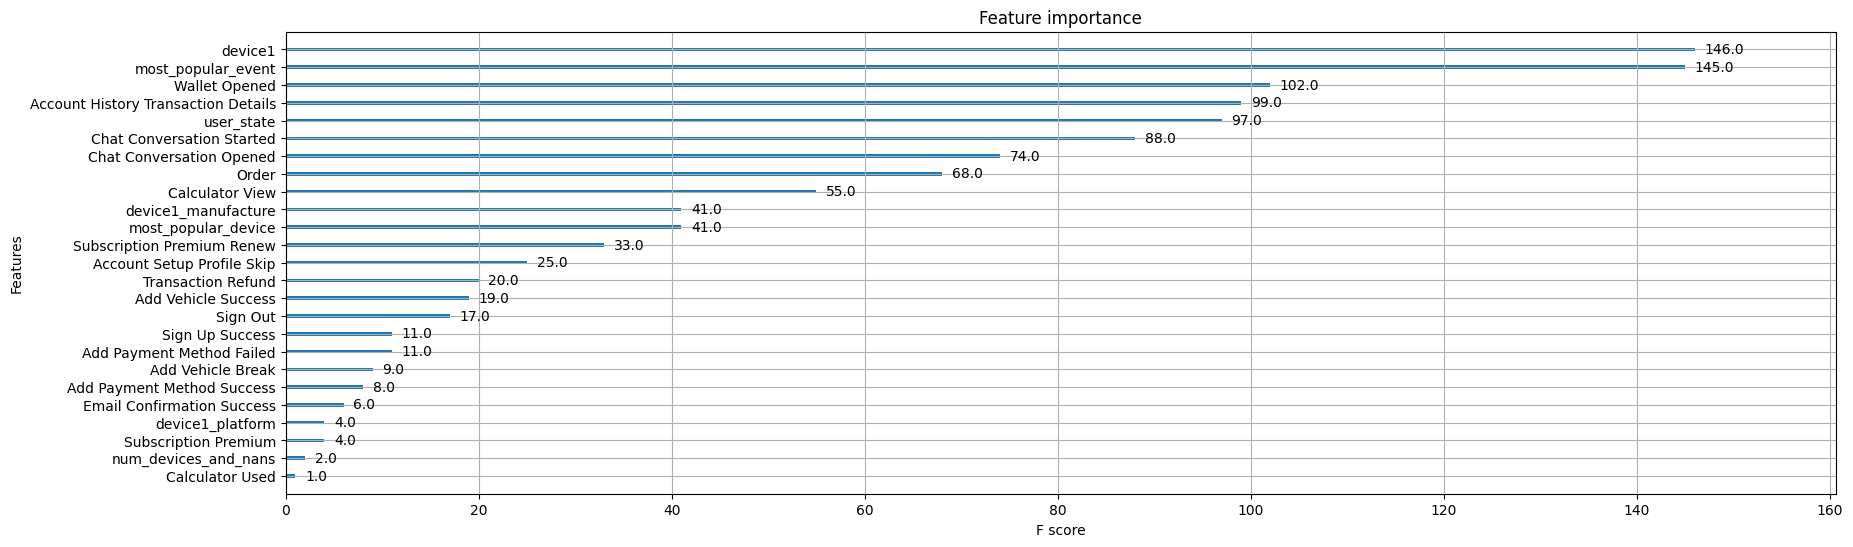

In [213]:
xgb.plot_importance(model)
plt.show()

In [214]:
y_test_pred = model.predict(X_test)

In [215]:
accuracy_score(y_test, y_test_pred)

0.8492462311557789

In [216]:
precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

(0.72, 0.8571428571428571)

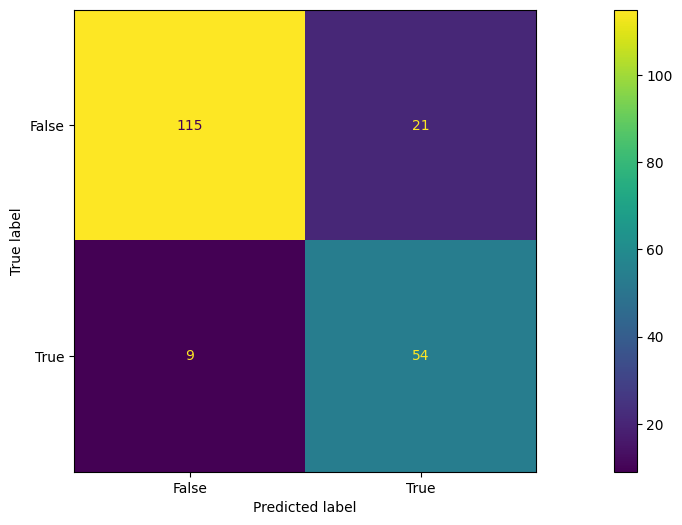

In [217]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

<AxesSubplot:>

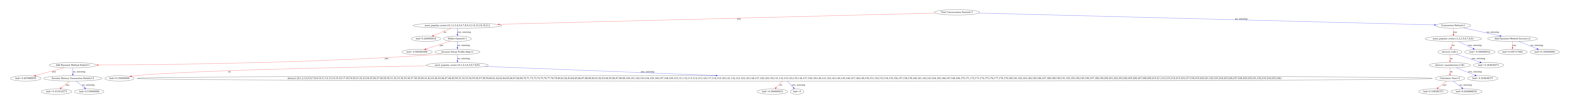

In [218]:
xgb.plot_tree(model)